Las cuatro redes de proteínas de levadura que
disponemos: Y2H, AP-MS, LIT y Lit-Reguly. Las dos últimas son redes construidas a partir de
interacciones reportadas en la literatura. 

In [2]:
#librerias a utilizar
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as scipy

In [3]:
#Para abrir archivos
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    if os.path.basename(nombre_archivo) == 'yeast_LIT_Reguly.txt':
        data = data[1:]
        enlaces = []
        for linea in data:
            enlaces.append(linea[:2])
        return(enlaces)
    if os.path.basename(nombre_archivo) == 'Essential_ORFs_paperHe.txt': 
        data = data[2:]
        esenciales = []
        for linea in data:
            if len(linea)>2:
                esenciales.append(linea[1])
        return esenciales
    else:
        return data

def crear_redes(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    return Red

In [4]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'AP_MS': './data/yeast_AP-MS.txt',
         'Lit': './data/yeast_LIT.txt',
         'Lit_reg': "./data/yeast_LIT_Reguly.txt"
         }
redes_dict = {}

for red in redes:
    grafo = crear_redes(redes[red])
    redes_dict[red] = {}
    redes_dict[red]["Grafo"] = grafo

# Tabla 1

In [5]:
def get_red_info(nombre_red):
    
    red = redes_dict[nombre_red]
    grafo = red['Grafo']
    red['Nodos'] = grafo.number_of_nodes() 
    red['Enlaces'] = grafo.number_of_edges()
    red['Grado medio'] = 2 * red['Enlaces'] / red['Nodos']
    red['Clustering medio'] = nx.average_clustering(grafo)   

In [6]:
for red in redes_dict.keys():
    get_red_info(red)

In [7]:
import pandas as pd

redes_df = redes_dict.copy() #no modificar data
df = pd.DataFrame(redes_dict).transpose()
df_sin_grafo = df.drop(columns = ['Grafo'])
df_sin_grafo = df_sin_grafo.astype({'Clustering medio': float, 'Grado medio': float})
df_sin_grafo.round({'Clustering medio': 2, 'Grado medio': 2})

,Clustering medio,Enlaces,Grado medio,Nodos
Y2H,0.05,2930,2.90,2018
AP_MS,0.55,9070,11.18,1622
Lit,0.29,2925,3.81,1536
Lit_reg,0.26,11858,7.17,3307


# Tabla 2

In [8]:
nodos = {}
enlaces = {}

for red in redes_dict:
    Red_proteinas = redes_dict[red]['Grafo']
    #Guardo enlaces y nodos en un set para poder hacer comparaciones facilmente
    enlaces[red], nodos[red] = set(), set()
    for nodo in Red_proteinas.nodes(): nodos[red].add(nodo)
    #Como los enlaces son NO dirigidos, los ordeno los nodos del enlace antes de guardarlo
    for enlace in Red_proteinas.edges(): enlace=sorted(enlace);enlaces[red].add((enlace[0],enlace[1]))

In [9]:
overlap_dict = {}  
lista_redes = list(redes_dict.keys())
lista_redes

['Y2H', 'AP_MS', 'Lit', 'Lit_reg']

In [10]:
def intersection(dicts):
    for key in dicts.keys():
        overlap_dict[key] = {}
        overlap_dict[key][key] = 0
        a = dicts[key]
        lista = ('b', 'c', 'd')
        for red in dicts.keys():
            if red == key:
                overlap_dict[key][key] = 0 
            else:
                interseccion = a.intersection(dicts[red])
                overlap_dict[key][red] = len(interseccion) / len(a)
            
                           
intersection(enlaces)     

In [11]:
overlap_dict

{'Y2H': {'Y2H': 0,
  'AP_MS': 0.08873720136518772,
  'Lit': 0.08873720136518772,
  'Lit_reg': 0.163481228668942},
 'AP_MS': {'AP_MS': 0,
  'Y2H': 0.02866593164277839,
  'Lit': 0.14310915104740904,
  'Lit_reg': 0.27783902976846747},
 'Lit': {'Lit': 0,
  'Y2H': 0.08888888888888889,
  'AP_MS': 0.4437606837606838,
  'Lit_reg': 0.9777777777777777},
 'Lit_reg': {'Lit_reg': 0,
  'Y2H': 0.040394670264800134,
  'AP_MS': 0.21251475796930341,
  'Lit': 0.24118738404452691}}

In [12]:
enlaces_df = overlap_dict.copy() #no modificar data
df = pd.DataFrame(enlaces_df).transpose()
df = df.astype(float).round(3)
for red, _ in df.iterrows():
    df.loc[df[red] == 0, red] = '-'
df


,AP_MS,Lit,Lit_reg,Y2H
Y2H,0.089,0.089,0.163,-
AP_MS,-,0.143,0.278,0.029
Lit,0.444,-,0.978,0.089
Lit_reg,0.213,0.241,-,0.04


Esta tabla se lee "De los enlaces de Y2H un 8.9% de sus enlaces también está en AP MS".

Esto no lo pide, pero podriamos ponerlo. Lo mismo una tabla para nodos. 

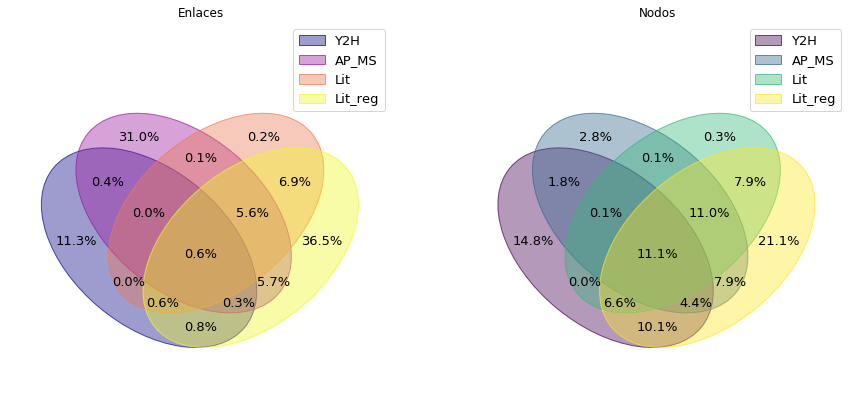

In [13]:
from venn import venn
f, axs = plt.subplots(1, 2 , figsize=(15,15))
venn_e = venn(enlaces, fmt="{percentage:.1f}%", ax= axs[0], cmap = "plasma")
axs[0].set_title("Enlaces")
venn(nodos, fmt="{percentage:.1f}%", ax= axs[1] )
axs[1].set_title("Nodos")
plt.show()

# Figura 1

In [120]:
lista_esenciales = abrir_txt('./data/Essential_ORFs_paperHe.txt')

grados_ordenados = {}

def segundo_lugar(item):
    return item[1]

for red in redes_dict.keys():
    grados_lista = list(redes_dict[red]['Grafo'].degree())
    grados_lista.sort(key = segundo_lugar, reverse = True)
    grados_ordenados[red] = grados_lista

In [134]:
from operator import itemgetter

def calcular_esenciales(red):
    
    nodos = list(map(itemgetter(0), grados_ordenados[red])) #lista de nodos ordenados por grado
    orden_grados = list(map(itemgetter(1), grados_ordenados[red])) #grados de dichos nodos
    
    hub_definition = []
    fraccion_hubs_esenciales = []

    for i in orden_grados:
        lista_nodos = []
        for j in range(0,len(nodos)):
            if orden_grados[j] >= i: 
                lista_nodos.append(nodos[j]) #solo si tienen mayor grado
        
        hub_definition.append(len(lista_nodos) / redes_dict[red]['Nodos']) #propocion de nodos que tomo como hub
        hubs_esenciales = set(lista_nodos).intersection(lista_esenciales) #nodos esenciales dentro de los hubs
        fraccion_hubs_esenciales.append(len(hubs_esenciales) / len(lista_nodos) ) #fraccion entre los hubs de esenciales       
        
    return hub_definition, fraccion_hubs_esenciales

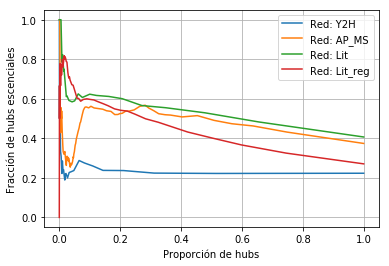

In [135]:
correlaciones = {}
for red in redes_dict.keys():
    x, y = calcular_esenciales(red)
    correlaciones[red] = {}
    correlaciones[red]['Kendall'] = scipy.kendalltau(x,y)[0]
    correlaciones[red]['Kendall p value'] = (scipy.kendalltau(x,y)[1])
    correlaciones[red]['Spearman'] = scipy.spearmanr(x,y)[0]
    correlaciones[red]['Spearman p value'] = scipy.spearmanr(x,y)[1]
    plt.plot(x, y, label = f'Red: {red}')
    plt.xlabel('Proporción de hubs')
    plt.ylabel('Fracción de hubs escenciales')
    plt.legend()
    

plt.grid()
plt.show()

In [136]:
correlaciones_df = correlaciones.copy() #no modificar data
df = pd.DataFrame(correlaciones_df).transpose()
df = df.astype(float).round(3)
df

,Kendall,Kendall p value,Spearman,Spearman p value
Y2H,-0.351,0.0,-0.448,0.0
AP_MS,-0.689,0.0,-0.693,0.0
Lit,-0.971,0.0,-0.994,0.0
Lit_reg,-0.995,0.0,-0.998,0.0


# Figura 3

Esto es igualito al ejercicio 2c del TPC_01.
Tenemos que considerar x centralidades:
* Remover nodos esenciales de una
* Random (ver código ya hecho)
* Eigenvalue: diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
* Degree centrality diccionario_centralidad_grado = nx.degree_centrality(Red)
* Shortest path diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
* current_flow 
* diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
*